In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score, auc

import tensorflow as tf
from tensorflow.keras.layers import Flatten, Conv2D, MaxPool2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

2025-04-26 11:44:06.952679: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path = './sports_celebrity_images'
celebrities = os.listdir(path)

counter = 1
celebrity_labels = {}
celebrity_image_paths = {}
images = []
labels = []

celebrities = os.listdir(path)
for name in celebrities:
    celebrity_labels[name] = counter
    celebrity_image_paths[name] = os.listdir(f'{path}/{name}/')[:100]
    counter += 1

df = pd.DataFrame(celebrity_image_paths)
# display(df)

for row in range(df.shape[0]):
    for column in range(df.shape[1]):
        name = df.columns[column]
        image_name = df.iloc[row, column]
        image = Image.open(f'{path}/{name}/{image_name}')
        image = image.resize((512, 512))
        images.append(image)
        labels.append(celebrity_labels[name])

# for name in celebrities:
#     celebrity_labels[name] = counter
#     counter += 1
#     for image_path in os.listdir(f'{path}/{name}')[:100]:
#         image = Image.open(f'{path}/{name}/{image_path}')
#         image = image.resize((512, 512))
#         images.append(image)
#         labels.append(celebrity_labels[name])

In [3]:
# index = 4
# celebrity_search = {i:j for j, i in celebrity_labels.items()}
# plt.imshow(images[index])
# print(celebrity_search[labels[index]], ':', labels[index])

In [3]:
x, y = np.array(images), np.array(labels)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9, test_size=0.1, random_state=5, shuffle=False)
x_train, x_test = x_train/255, x_test/255

def OneHotEncoder(list):
    y_train_ohe = []
    for i in list:
        temp = np.zeros(shape=(4,))
        temp[i-1] = 1
        y_train_ohe.append(temp)
    y_train_ohe = np.array(y_train_ohe)
    return y_train_ohe
    
y_train = OneHotEncoder(y_train)
y_test = OneHotEncoder(y_test)

In [4]:
input_shape = x_train.shape[1:]

model = Sequential()
model.add( Conv2D(16, kernel_size=(3, 3), input_shape=input_shape, activation='relu') )
model.add( MaxPool2D(pool_size=(2, 2)) )
model.add( Conv2D(32, kernel_size=(3, 3), activation='relu') )
model.add( MaxPool2D(pool_size=(2, 2)) )

model.add( Flatten() )
model.add( Dense(128) )
model.add( Dropout(0.2) )
model.add( Dense(4, activation='softmax') )

model.summary()

2025-04-26 11:38:01.214231: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 64)       0

In [5]:
batch_size = 32
epochs = 30
callback = EarlyStopping(monitor='val_loss', patience=3)

model.compile( optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'] )
history = model.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_test, y_test),
    shuffle = True,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 2,
    callbacks = callback
)

Epoch 1/30
12/12 - 26s - loss: 18.7051 - accuracy: 0.2889 - val_loss: 1.3045 - val_accuracy: 0.3750 - 26s/epoch - 2s/step
Epoch 2/30
12/12 - 21s - loss: 1.2681 - accuracy: 0.4750 - val_loss: 1.2820 - val_accuracy: 0.3250 - 21s/epoch - 2s/step
Epoch 3/30
12/12 - 20s - loss: 0.9591 - accuracy: 0.6083 - val_loss: 1.1413 - val_accuracy: 0.5250 - 20s/epoch - 2s/step
Epoch 4/30
12/12 - 20s - loss: 0.5915 - accuracy: 0.8472 - val_loss: 1.5015 - val_accuracy: 0.5250 - 20s/epoch - 2s/step
Epoch 5/30
12/12 - 20s - loss: 0.2663 - accuracy: 0.9167 - val_loss: 1.3244 - val_accuracy: 0.5750 - 20s/epoch - 2s/step
Epoch 6/30
12/12 - 20s - loss: 0.0747 - accuracy: 0.9917 - val_loss: 1.4804 - val_accuracy: 0.5750 - 20s/epoch - 2s/step


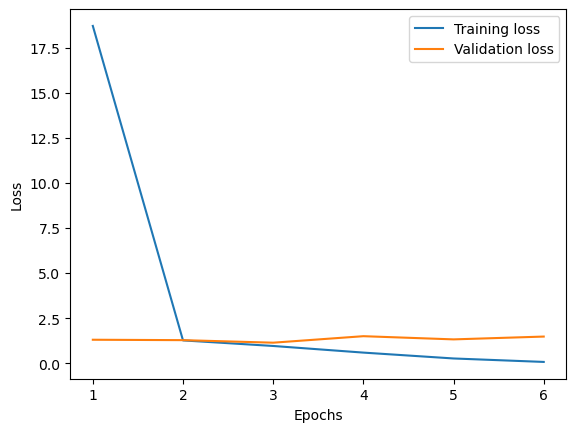

In [6]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

fig, ax = plt.subplots()
ax.plot(epochs, loss, label='Training loss')
ax.plot(epochs, val_loss, label='Validation loss')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_xticks(epochs)
plt.show()

In [7]:
predictions = model.predict(x_test)
y_test = np.argmax(y_test, axis=1)
predictions = np.argmax(predictions, axis=1)
confusion_matrix(y_test, predictions)

2/2 [==============================] - 1s 191ms/step


array([[5, 4, 1, 0],
       [1, 7, 2, 0],
       [0, 1, 8, 1],
       [3, 1, 3, 3]])

In [9]:
model.save('best_classification.keras')